In [39]:
import numpy as np
from SimPEG.electromagnetics import natural_source as nsem
from SimPEG import maps
import matplotlib.pyplot as plt
import matplotlib
from SimPEG.utils import plot_1d_layer_model
from discretize import TensorMesh
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
matplotlib.rcParams['font.size'] = 14

In [40]:
# The same model from XXX
layer_tops = np.r_[0., -600., -1991., -5786., -9786.][::-1]  # in m
layer_thicknesses = np.diff(layer_tops)
rho_layers = np.r_[250., 25, 100., 10., 25.][::-1]

frequencies = np.logspace(-3, 3, 31)

In [41]:
mesh = TensorMesh([(np.r_[layer_thicknesses, layer_thicknesses[-1]])], "N")

wire_map = maps.Wires(("sigma", mesh.nC), ("t", mesh.nC - 1))
sigma_map = maps.ExpMap(nP=mesh.nC) * wire_map.sigma
layer_map = maps.ExpMap(nP=mesh.nC - 1) * wire_map.t


sigma_map = maps.ExpMap(nP=len(rho_layers))

receivers_list = [
    nsem.receivers.PointNaturalSource(component="app_res"),
    nsem.receivers.PointNaturalSource(component="phase"),
]

source_list = []
for freq in frequencies:
    source_list.append(nsem.sources.Planewave(receivers_list, freq))

survey = nsem.survey.Survey(source_list)

simulation = nsem.simulation_1d.Simulation1DRecursive(
    survey=survey, 
    sigmaMap=sigma_map,
    thicknesses=layer_thicknesses,
)

true_model = np.r_[np.log(1./rho_layers)]

dpred = simulation.dpred(true_model)
amp = dpred.reshape((len(frequencies), 2))[:,0]
phase = dpred.reshape((len(frequencies), 2))[:,1]
std = np.c_[abs(amp)*0.05, np.ones(len(phase))*2].flatten()
noise = np.c_[np.random.randn(amp.size)*0.05*abs(amp), np.random.randn(amp.size)*2].flatten()
dobs = dpred + noise

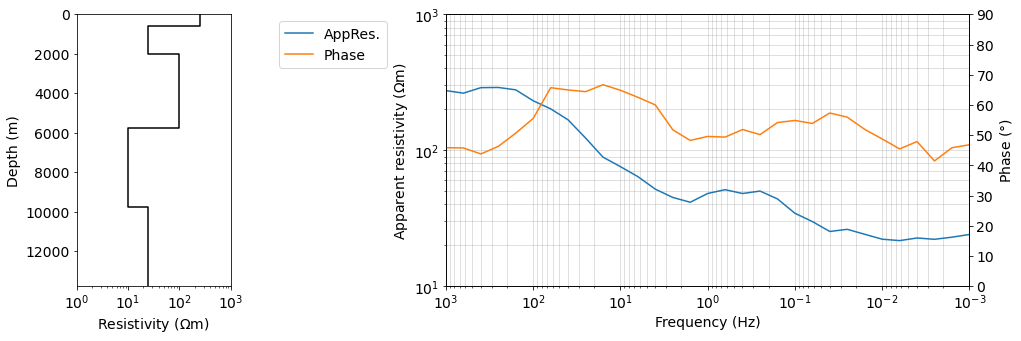

In [42]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 5, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
plot_1d_layer_model(layer_thicknesses[::-1], rho_layers[::-1], ax=ax0, color="k", **{'label':'True'})
ax0.set_xlabel("Resistivity ($\Omega$m)")
ax0.set_xlim(1, 1000)
# ax0.set_yscale('log')
ax = fig.add_subplot(gs[0, 2:])
ax.loglog(frequencies, dobs.reshape((len(frequencies), 2))[:,0], color='C0', label='AppRes.')
ax.loglog(frequencies[0], dobs.reshape((len(frequencies), 2))[0,0], color='C1', label='Phase')
ax_1 = ax.twinx()
ax_1.plot(frequencies, dobs.reshape((len(frequencies), 2))[:,1], color='C1')
ax.set_xlabel("Frequency (Hz)")    
ax.set_ylim(10, 1000)
ax_1.set_ylim(0, 90)    
ax.grid(True, which='both', alpha=0.5)
ax.set_ylabel("Apparent resistivity ($\Omega$m)")
ax_1.set_ylabel("Phase ($\degree$)")
ax.legend(bbox_to_anchor=(-0.1, 1))
ax.set_xlim(frequencies.max(), frequencies.min())
plt.show()

In [43]:
dz = 50
n_layer = 21
layer_thicknesses_inv = dz*1.1*np.arange(n_layer-1)[::-1]
mesh_inv = TensorMesh([(np.r_[layer_thicknesses_inv, layer_thicknesses_inv[-1]])], "N")
sigma_map = maps.ExpMap(nP=len(layer_thicknesses_inv)+1)
simulation = nsem.simulation_1d.Simulation1DRecursive(
    survey=survey, 
    sigmaMap=sigma_map,
    thicknesses=layer_thicknesses_inv,
)

In [44]:
data_object = data.Data(survey, dobs=dpred, standard_deviation=std)

In [45]:
starting_model = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./10.)
mref = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./100.)

In [46]:
dmis = data_misfit.L2DataMisfit(simulation=simulation, data=data_object)

# Define the regularization (model objective function)
reg = regularization.Simple(mesh_inv, alpha_s=1e-5, alpha_x=1.0, mref=mref)

# Define how the optimization problem is solved. Here we will use an inexact
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.InexactGaussNewton(maxIter=30, maxIterCG=50)

# Define the inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

#######################################################################
# Define Inversion Directives
# ---------------------------
#
# Here we define any directives that are carried out during the inversion. This
# includes the cooling schedule for the trade-off parameter (beta), stopping
# criteria for the inversion and saving inversion results at each iteration.
#

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=1.0)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# The directives are defined as a list.
directives_list = [
    starting_beta,
    beta_schedule,
    target_misfit,
]

#####################################################################
# Running the Inversion
# ---------------------
#
# To define the inversion object, we need to define the inversion problem and
# the set of directives. We can then run the inversion.
#

# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run the inversion
recovered_model = inv.run(starting_model)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.00e+07  4.28e+03  5.57e-04  1.54e+04    2.56e+03      0              
   1  1.00e+07  1.14e+04  1.22e-05  1.15e+04    1.47e+04      0              
   2  5.00e+06  1.64e+03  4.33e-05  1.85e+03    1.95e+03      0              
   3  2.50e+06  2.94e+02  9.98e-05  5.44e+02    2.25e+02      0   Skip BFGS  
   4  1.25e+06  1.05e+02  1.30e-04  2.67e+02    1.21e+02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.5418e+03
0 : |xc-x_last| = 1.2098e+00 <= tolX*(1+|x0|) = 1.1552e+00
0 : |proj(x-g)-x

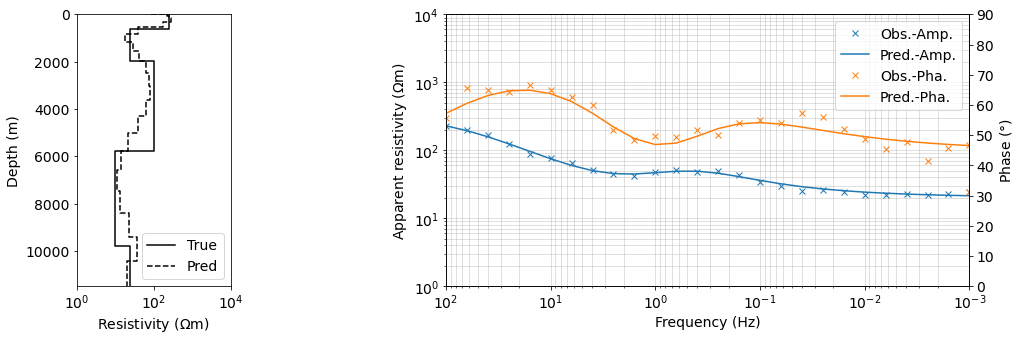

In [47]:
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 5, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
x_min = np.min([np.min(sigma_map * recovered_model), np.min(true_model)])
x_max = np.max([np.max(sigma_map * recovered_model), np.max(true_model)])

plot_1d_layer_model(layer_thicknesses[::-1], rho_layers[::-1], ax=ax0, color="k", **{'label':'True'})
plot_1d_layer_model(
    layer_thicknesses_inv[::-1],
    (1./(sigma_map * recovered_model))[::-1],
    ax=ax0,
    color="k",**{'label':'Pred', 'linestyle':'--'}
)
ax0.legend()
ax0.set_xlabel("Resistivity ($\Omega$m)")
ax0.set_xlim(1, 1e4)

ax = fig.add_subplot(gs[0, 2:])
ax.loglog(frequencies, dobs.reshape((len(frequencies), 2))[:,0], 'x', color='C0', label='Obs.-Amp.')
ax.loglog(frequencies, inv_prob.dpred.reshape((len(frequencies), 2))[:,0], color='C0', label='Pred.-Amp.')
ax.loglog(frequencies[0], dobs.reshape((len(frequencies), 2))[0,0], 'x', color='C1', label='Obs.-Pha.')
ax.loglog(frequencies[0], dobs.reshape((len(frequencies), 2))[0,0], color='C1', label='Pred.-Pha.')

ax_1 = ax.twinx()
ax_1.plot(frequencies, dobs.reshape((len(frequencies), 2))[:,1], 'x', color='C1', label='Obs.-Pha.')
ax_1.plot(frequencies, inv_prob.dpred.reshape((len(frequencies), 2))[:,1], color='C1', label='Pred.-Pha.')
ax.set_xlabel("Frequency (Hz)")
ax.grid(True, which='both', alpha=0.5)
ax.set_ylabel("Apparent resistivity ($\Omega$m)")
ax_1.set_ylabel("Phase ($\degree$)")
# ax.legend(bbox_to_anchor=(1.1,1))
ax.legend()
ax.set_ylim(1, 10000)
ax_1.set_ylim(0, 90)    
ax0.set_xlim(1, 10000)
ax.set_xlim(100, 0.001)

plt.show()